In [ ]:
# !rm -rf split_dataset
# !rm -rf dataset
# !rm -rf lung-cancer

In [2]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
-rw-r--r-- 1 root root 68 Jun  6 17:04 kaggle.json


In [3]:
!kaggle datasets download -d waseemnagahhenes/lung-cancer-dataset-iq-othnccd

 99% 259M/261M [00:10<00:00, 35.4MB/s]
100% 261M/261M [00:10<00:00, 25.3MB/s]


In [4]:
# unzip file

import zipfile

zip_path = 'lung-cancer-dataset-iq-othnccd.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('lung-cancer/')
zip_ref.close()

In [5]:
#rename base folder
import os

base_dir = '/content/lung-cancer/Data/The IQ-OTHNCCD lung cancer dataset'

os.rename(base_dir, 'dataset')

base_dir = 'dataset/'

labels = []
#rename dirs
for (root, dirs, files) in os.walk(base_dir):
  for name in dirs:
    x = name.split()[0].lower()
    labels.append(x)
    os.rename(base_dir+name, base_dir+x)

print(f'rename to : {labels}')

rename to : ['bengin', 'malignant', 'normal']


In [6]:
# before split
for label in labels:
  count = len(os.listdir(base_dir+label))
  print(f'{label} files count : {count}')

bengin files count : 120
malignant files count : 1339
normal files count : 614


In [7]:
#split dataset
!pip install split-folders
import splitfolders

new_base_dir = 'split_dataset'
splitfolders.ratio(base_dir, output='split_dataset', seed=50, ratio=(0.8, 0.1, 0.1), group_prefix=None)

base_dir = new_base_dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 2073 files [00:01, 1706.01 files/s]


In [8]:
# count dataset after split
splits = ['train', 'test', 'val']
totals = dict.fromkeys(splits)

# init 0 total
for split in splits:
  totals[split] = 0

# count splits file
for label in labels:
  for split in splits:
    count = len(os.listdir(base_dir+'/'+split+'/'+label))

    # count total every split
    totals[split] += count
    print(f'{split} {label} count : {count}')
  print('\n')

print(f'{totals}')

train bengin count : 96
test bengin count : 12
val bengin count : 12


train malignant count : 1071
test malignant count : 135
val malignant count : 133


train normal count : 491
test normal count : 62
val normal count : 61


{'train': 1658, 'test': 209, 'val': 206}


In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [10]:
print(f'{train_dir}, {val_dir}, {test_dir}')

split_dataset/train, split_dataset/val, split_dataset/test


Preprocessing imagee :)

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as Image

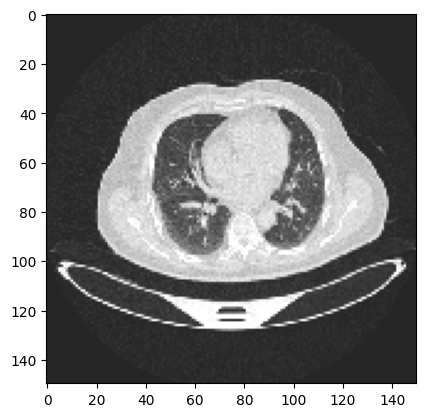

In [12]:
path = '/content/split_dataset/train/bengin/Bengin case (1).jpg'
ct_image = Image.load_img(path, target_size=(150,150))

plt.imshow(ct_image)


Lets start creating model

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

In [14]:
# import resnet50

from tensorflow.keras.applications.resnet50 import ResNet50

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("\Accuracy telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.5,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=30,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=30,
    shuffle=True,
    class_mode='categorical'
)

Found 1658 images belonging to 3 classes.
Found 206 images belonging to 3 classes.


In [18]:
# model = tf.keras.models.Model(pre_trained_model.input, x)

model = tf.keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.3),
    keras.layers.Conv2D(256, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
  ])


In [19]:
print(f'{model}')

In [20]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 20,
    batch_size = 120,
    callbacks=[callbacks]
)

Epoch 1/20
56/56 [==============================] - 36s 357ms/step - loss: 1.0817 - accuracy: 0.5977 - val_loss: 0.7407 - val_accuracy: 0.7039
Epoch 2/20
56/56 [==============================] - 18s 326ms/step - loss: 0.6772 - accuracy: 0.6930 - val_loss: 0.6218 - val_accuracy: 0.6456
Epoch 3/20
56/56 [==============================] - 19s 343ms/step - loss: 0.5866 - accuracy: 0.7232 - val_loss: 0.5296 - val_accuracy: 0.7427
Epoch 4/20
56/56 [==============================] - 19s 348ms/step - loss: 0.5631 - accuracy: 0.7346 - val_loss: 0.5498 - val_accuracy: 0.6942
Epoch 5/20
56/56 [==============================] - 19s 346ms/step - loss: 0.5580 - accuracy: 0.7425 - val_loss: 0.5012 - val_accuracy: 0.8058
Epoch 6/20
56/56 [==============================] - 18s 325ms/step - loss: 0.5567 - accuracy: 0.7557 - val_loss: 0.5011 - val_accuracy: 0.7718
Epoch 7/20
56/56 [==============================] - 19s 344ms/step - loss: 0.5503 - accuracy: 0.7485 - val_loss: 0.5776 - val_accuracy: 0.7282

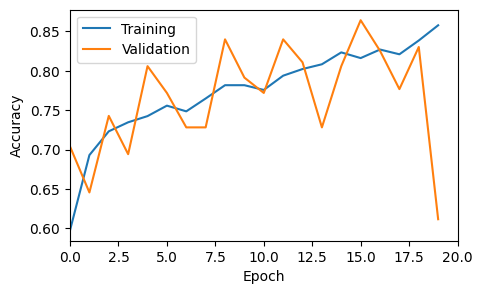

In [22]:
# plt.title('Akurasi Data Training & Validation')
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0,20)
plt.legend()
plt.show()

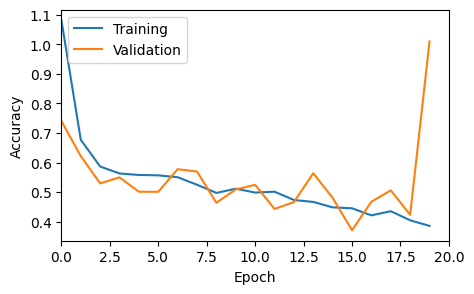

In [23]:
# plt.title('Loss Data Training & Validation')
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0,20)
plt.legend()
plt.show()

Predict Image

1/1 [==============================] - 0s 271ms/step


array([[9.769535e-10, 0.000000e+00, 1.000000e+00]], dtype=float32)

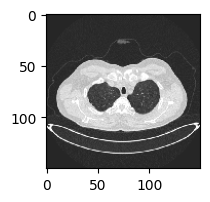

In [24]:
path1 = '/content/split_dataset/test/malignant/Malignant case (68).jpg'
path2 = '/content/split_dataset/test/bengin/Bengin case (19).jpg'
path3 = '/content/split_dataset/test/normal/Normal case (13).jpg'
gambar = Image.load_img(path2, target_size=(150,150))
img = Image.img_to_array(gambar)
img = np.expand_dims(img, axis=0)
img = np.vstack([img])

plt.figure(figsize=(2,2))
plt.imshow(gambar)
model.predict(img)

In [25]:
json_model = model.to_json()


#save the model to json
with open("ct_lung_model.json", "w") as json_file:
  json_file.write(json_model)